In [1]:
!git clone https://github.com/patitimoner/workshop-chihuahua-vs-muffin.git

%cd workshop-chihuahua-vs-muffin

!ls

Cloning into 'workshop-chihuahua-vs-muffin'...
remote: Enumerating objects: 337, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 337 (delta 1), reused 4 (delta 1), pack-reused 330 (from 1)
Receiving objects: 100% (337/337), 14.51 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/workshop-chihuahua-vs-muffin
'CNN_1 Chihuahua or Muffin.ipynb'   README.md   workshop_1.ipynb
 data				    resources   workshop_1_output.ipynb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# I.  Project Overview

<center><img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/preview.jpg?raw=1" width="700"></center>

In this project, we'll build a neural network classifier that determines: **MUFFIN... or CHIHUAHUA!**

This is what we'll cover in the tutorial:
#### 1) Build the neural network
#### 2) Load the data
#### 3) Train the model on the data
#### 4) Visualize the results

### Remember: This is an INTERACTIVE Notebook!
You should run and play with the code as you go to see how it works. Select a cell and **press shift-enter to execute code.**

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/jupyter_animated.gif?raw=1" width="700">

# II.  Deep Learning Tutorial

Let's get to the fun stuff!



<center><img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/Pytorch_logo.png?raw=1" width="700"></center>

**Generic Python imports** (select the below cell and press shift-enter to execute it)

In [103]:
import matplotlib.pyplot as plt  # graphical library, to plot images
# special Jupyter notebook command to show plots inline instead of in a new window
%matplotlib inline

**Deep learning imports**

In [193]:
import torch                                            # PyTorch deep learning framework
from torchvision import datasets, models, transforms    # extension to PyTorch for dataset management
import torch.nn as nn                                   # neural networks module of PyTorch, to let us define neural network layers
from torch.nn import functional as F                    # special functions
import torch.optim as optim                             # optimizers

## (1) Build our Neural Network

Recall from the lesson that a neural network generally looks like this. Input is on the left, output is on the right. The number of output neurons correspond to the number of classes.

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/what_is_nn_slide.jpg?raw=1" width="700">

So let's define a similar architecture for our 2-class muffin-vs-chihuahua classifier:

Changed image height and weight to 128 and neurons increased starting at 256...

In [194]:
#define image height and width
input_height = 128
input_width = 128

# Extends PyTorch's neural network baseclass
class MySkynet(nn.Module):
    """
    A very basic neural network.
    """
    def __init__(self, input_dim=(3, input_height, input_width)):
        """
        Constructs a neural network.

        input_dim: a tuple that represents "channel x height x width" dimensions of the input
        """
        super().__init__()
        # the total number of RGB pixels in an image is the tensor's volume
        num_in_features = input_dim[0] * input_dim[1] * input_dim[2]
        # input layer
        self.layer_0 = nn.Linear(num_in_features, 128)
        # hidden layers
        self.layer_1 = nn.Linear(128, 64)
        self.layer_2= nn.Linear(64, 32)
        # output layer, output size of 2 for chihuahua and muffin
        self.layer_3= nn.Linear(32, 2)


    def forward(self, x):
        """
        Define the forward pass through our network.
        """
        batch_size = x.shape[0]
        # convert our RGB tensor into one long vector
        x = x.view(batch_size, -1)

        # pass through our layers
        x = F.relu(self.layer_0(x))
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))

        # convert the raw output to probability predictions
        x = F.softmax(x, dim=1)

        return x

Added another layer and increased the number of neurons per layer that resulted in underfitting. Reduced neurons and removed the extra layer that allowed for 99% accuracy for final try. **Try more optimnizers later with different datasets for personalized models.**

Now that we've defined the network above, let's initialize it. If available, we'll place the network on the GPU; if not, it goes on the CPU.

The next code block was the first challenge. Not including "3" for the RBG channels kept returning an error message. MySkyNet was defined in the previous cell so that was simple to enter but I had to remember the shape I am loading in Python that requires  batch size, image height and width.

In [195]:
 # cuda:0 means the first cuda device found
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MySkynet(input_dim=(3, input_height, input_width)).to(device)                     # load our simple neural network
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

Essentially, our network looks like this:
<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/architecture.png?raw=1" width="600">

## (2) Data and Data Loading

### Separate "train" and "test" datasets

Recall from the below slide, we should make two separate datasets to train and test our model. That way, we know our model learns more than rote memorization.

<center><img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/when_is_your_model_ready_slide.jpg?raw=1" width="600"></center>

### Inspect our data
Let's look in our data folder to see what's there. As you can see, the folder is **split into "train" for training**, and **"validation" for testing** (to validate our model).

In [196]:
import os  # interact with the os. in our case, we want to view the file system

print("Data contents:", os.listdir("data"))
print("Train contents:", os.listdir("data/train"))
print("Validation contents:", os.listdir("data/validation"))

Data contents: ['train', 'validation']
Train contents: ['muffin', 'chihuahua']
Validation contents: ['muffin', 'chihuahua']


Let's also look at some of the images:

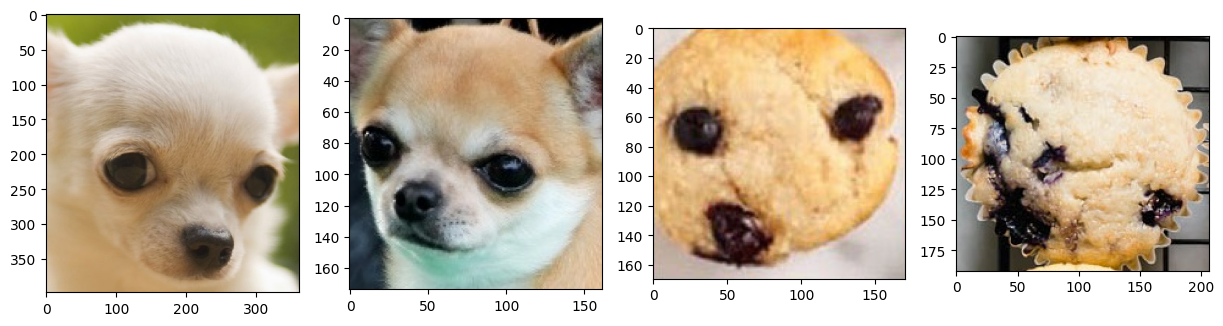

In [197]:
from PIL import Image  # import our image opening tool

_, ax = plt.subplots(1, 4, figsize=(15,60))  # to show 4 images side by side, make a "1 row x 4 column" axes
ax[0].imshow(Image.open("data/train/chihuahua/4.jpg"))  # show the chihuahua in the first column
ax[1].imshow(Image.open("data/train/chihuahua/5.jpg"))  # show the chihuahua in the second column
ax[2].imshow(Image.open("data/train/muffin/131.jpg"))   # show the muffin in the third column
ax[3].imshow(Image.open("data/train/muffin/107.jpg"))   # show the muffin in the fourth column


If you look in the data folder on your computer, there are 120 train images and 30 validation. So our data is split like this:

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/folders.png?raw=1" width="600">

### Load our data

That's great that we have data! But we have to load all the images and convert them into a form that our neural network understands. Specifically, PyTorch works with **Tensor** objects. (A tensor is just a multidimensional matrix, i.e. an N-d array.)

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/image_to_tensor.jpg?raw=1" width="550">


**To easily convert our image data into tensors, we use the help of a "dataloader."** The dataloader packages data into convenient boxes for our model to use. You can think of it like one person passing boxes (tensors) to another.
<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/dataloader_box_analogy.jpg?raw=1" width="400">

**First, we define some "transforms" to convert images to tensors.** We must do so for both our train and validation datasets.

For more information about transforms, check out the link here: https://pytorch.org/docs/stable/torchvision/transforms.html

Below I manipulated the transforms.Resize from input_height/weight to 64, 96, 128... Ultimately settling back to original input_size and input_weight.

In [198]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

# transforms for our training data
train_transforms = transforms.Compose([
    # resize to resnet input size
    transforms.Resize((input_height, input_width)),
    # transform image to PyTorch tensor object
    transforms.ToTensor(),
    normalize
])

# these validation transforms are exactly the same as our train transforms
validation_transforms = transforms.Compose([
    transforms.Resize((input_height, input_width)),
    transforms.ToTensor(),
    normalize
])

print("Train transforms:", train_transforms)

Train transforms: Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


Added RandomRotation to teach model the muffin and chihuahua at various angles to try and increase accuracy BUT that was a failure. The model learns a muffin is a muffin even if upside down or a chihuahua is a chihuahua when looking in different directions, is flipped, etc. to train on the features on the images and better recognize in training images.

**Second, we create the datasets, by passing the transforms into the ImageFolder constructor.**

These just represent the folders that hold the images.

Remember PyTorch expects a transform, not a class. Chihuahua means nothing to PyTorch

In [199]:
# insert respective transforms to replace ?
image_datasets = {
    'train':
        datasets.ImageFolder('data/train', transform=train_transforms),
    'validation':
        datasets.ImageFolder('data/validation', transform=validation_transforms)}  # Retrieved from previous cell


print("==Train Dataset==\n", image_datasets["train"])
print()
print("==Validation Dataset==\n", image_datasets["train"])

==Train Dataset==
 Dataset ImageFolder
    Number of datapoints: 120
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

==Validation Dataset==
 Dataset ImageFolder
    Number of datapoints: 120
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


**And finally, form dataloaders from the datasets:**

Got a "Warning to lower the number of workers" due to size limit, 4, which would cause it to freeze!

In [200]:
# define batch size, number of images to load in at once

dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=3,
            shuffle=True,
            num_workers=2),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=3,
            shuffle=False,
            num_workers=2)}

print("Train loader:", dataloaders["train"])
print("Validation loader:", dataloaders["validation"])

Train loader: <torch.utils.data.dataloader.DataLoader object at 0x7ad86d80ce30>
Validation loader: <torch.utils.data.dataloader.DataLoader object at 0x7ad86d80eff0>


We can see a dataloader outputs 2 things: a BIG tensor to represent an image, and a vector to represent the labels (0 or 1).

In [201]:
next(iter(dataloaders["train"]))

[tensor([[[[ 0.5843,  0.7020,  0.7333,  ...,  0.6392,  0.6549,  0.6784],
           [ 0.6157,  0.7804,  0.8196,  ...,  0.5843,  0.6235,  0.6627],
           [ 0.6627,  0.8431,  0.8745,  ...,  0.4431,  0.4980,  0.5608],
           ...,
           [ 0.7333,  0.7333,  0.7098,  ..., -0.1765, -0.1922, -0.1843],
           [ 0.7725,  0.7490,  0.7333,  ..., -0.2000, -0.2000, -0.1843],
           [ 0.7961,  0.7647,  0.7647,  ..., -0.1922, -0.2000, -0.1451]],
 
          [[ 0.5216,  0.4588,  0.3804,  ...,  0.5451,  0.5608,  0.5843],
           [ 0.4745,  0.4980,  0.4745,  ...,  0.3961,  0.4353,  0.4745],
           [ 0.4980,  0.5686,  0.5922,  ...,  0.2235,  0.2706,  0.3333],
           ...,
           [ 0.7882,  0.7961,  0.7961,  ..., -0.1373, -0.1686, -0.1922],
           [ 0.8039,  0.7804,  0.7882,  ..., -0.1529, -0.1686, -0.1765],
           [ 0.8118,  0.7804,  0.7961,  ..., -0.1765, -0.1922, -0.1373]],
 
          [[ 0.5451,  0.6549,  0.6549,  ...,  0.4824,  0.5216,  0.5451],
           [ 

## (4) Train the model!

Hurray! We've built a neural network and have data to give it. Now we **repeatedly iterate over the data to train the model.**

Every time the network gets a new example, it looks something like this. Note the **forward pass** and the corresponding **backward pass**.

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/backpropagation.gif?raw=1" width="700">

### Define the train loop

We want the network to learn from every example in our training dataset. However, the best performance comes from more practice. Therefore, we **run through our dataset for multiple *epochs*.**

After each epoch, we'll check how our model performs on the validation set to monitor its progress.

In [202]:
from tqdm import tnrange, tqdm_notebook # import progress bars to show train progress

def train_model(model, dataloaders, loss_function, optimizer, num_epochs):
    """
    Trains a model using the given loss function and optimizer, for a certain number of epochs.

    model: a PyTorch neural network
    loss_function: a mathematical function that compares predictions and labels to return an error
    num_epochs: the number of times to run through the full training dataset
    """
    # train for n epochs. an epoch is a full iteration through our dataset
    for epoch in tnrange(num_epochs, desc="Total progress", unit="epoch"):
        # print a header
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('----------------')

        # first train over the dataset and update weights; at the end, calculate our validation performance
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # keep track of the overall loss and accuracy for this batch
            running_loss = 0.0
            running_corrects = 0

            # iterate through the inputs and labels in our dataloader
            # (the tqdm_notebook part is to display a progress bar)
            for inputs, labels in tqdm_notebook(dataloaders[phase], desc=phase, unit="batch", leave=False):
                # move inputs and labels to appropriate device (GPU or CPU)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # FORWARD PASS
                outputs = model(inputs)
                # compute the error of the model's predictions
                loss = loss_function(outputs, labels)

                if phase == 'train':
                    # BACKWARD PASS
                    optimizer.zero_grad()  # clear the previous gradients
                    loss.backward()        # backpropagate the current error gradients
                    optimizer.step()       # update the weights (i.e. do the learning)

                # track our accumulated loss
                running_loss += loss.item() * inputs.size(0)
                # track number of correct to compute accuracy
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            # print our progress
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f'{phase} error: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        print()

### Loss function and optimizer

One last thing: we must define a function that gives feedback for how well the model performs. This is the **loss**, or "error" **function**, that compares model predictions to the true labels.

Once we calculate the error, we also need to define how the model should react to that feedback. **The optimizer determines how the network learns from feedback.**

In [203]:
loss_function = nn.CrossEntropyLoss()              # the most common error function in deep learning
optimizer = optim.SGD(model.parameters(), lr=0.01)  # Stochastic Gradient Descent, with a learning rate of 0.1

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/gradient_descent.gif?raw=1" width="700">

Still have do not fully understand the function curve, cross entropy loss...**research to gain better understanding.**

### Run training

Let's put everything together and TRAIN OUR MODEL! =D

Changed epoachs for more learning opportunities and increase accuracy, to 20 after 50 resulted in underfitting and 100% chihuahua on every image lol. Also reduced lr to .1 again after lr .5 and .35 resulted in large(r) gaps. Incresed epochs to 25 after also increasing lr to .2 and adding random rotation. Reduced lr to .1 and kept epochs at 25. Will change the optimizer to test.

In [204]:
train_model(model, dataloaders, loss_function, optimizer, num_epochs=25)

/tmp/ipython-input-963760017.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(num_epochs, desc="Total progress", unit="epoch"):


Total progress:   0%|          | 0/25 [00:00<?, ?epoch/s]

Epoch 1/25
----------------


/tmp/ipython-input-963760017.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm_notebook(dataloaders[phase], desc=phase, unit="batch", leave=False):


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.6822, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.6729, Accuracy: 0.5667

Epoch 2/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.6654, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.6544, Accuracy: 0.5667

Epoch 3/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.6441, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.6313, Accuracy: 0.5667

Epoch 4/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.6192, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.6102, Accuracy: 0.5667

Epoch 5/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.5907, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.5894, Accuracy: 0.5667

Epoch 6/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.5632, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.5846, Accuracy: 0.5667

Epoch 7/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.5438, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.5685, Accuracy: 0.5667

Epoch 8/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.5292, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.5723, Accuracy: 0.5667

Epoch 9/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.5231, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.5629, Accuracy: 0.5667

Epoch 10/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.5143, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.5794, Accuracy: 0.5667

Epoch 11/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.5116, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.5639, Accuracy: 0.5667

Epoch 12/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.5079, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.5779, Accuracy: 0.5667

Epoch 13/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.4978, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.5749, Accuracy: 0.5667

Epoch 14/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.4958, Accuracy: 0.5417


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.6114, Accuracy: 0.5667

Epoch 15/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.4880, Accuracy: 0.7000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.5549, Accuracy: 0.8000

Epoch 16/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.3823, Accuracy: 1.0000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.4734, Accuracy: 0.8667

Epoch 17/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.3414, Accuracy: 1.0000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.4712, Accuracy: 0.8333

Epoch 18/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.3298, Accuracy: 1.0000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.4684, Accuracy: 0.8667

Epoch 19/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.3243, Accuracy: 1.0000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.4613, Accuracy: 0.8333

Epoch 20/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.3212, Accuracy: 1.0000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.4566, Accuracy: 0.8333

Epoch 21/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.3194, Accuracy: 1.0000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.4568, Accuracy: 0.8333

Epoch 22/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.3182, Accuracy: 1.0000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.4560, Accuracy: 0.8333

Epoch 23/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.3174, Accuracy: 1.0000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.4544, Accuracy: 0.8333

Epoch 24/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.3168, Accuracy: 1.0000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.4552, Accuracy: 0.8333

Epoch 25/25
----------------


train:   0%|          | 0/40 [00:00<?, ?batch/s]

train error: 0.3163, Accuracy: 1.0000


validation:   0%|          | 0/10 [00:00<?, ?batch/s]

validation error: 0.4546, Accuracy: 0.8333



## Examine model performance

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/question_mark.jpg?raw=1" width="200" >

**How do we examine our model's predictions? Let's visualize what the model thinks on the validation set.**

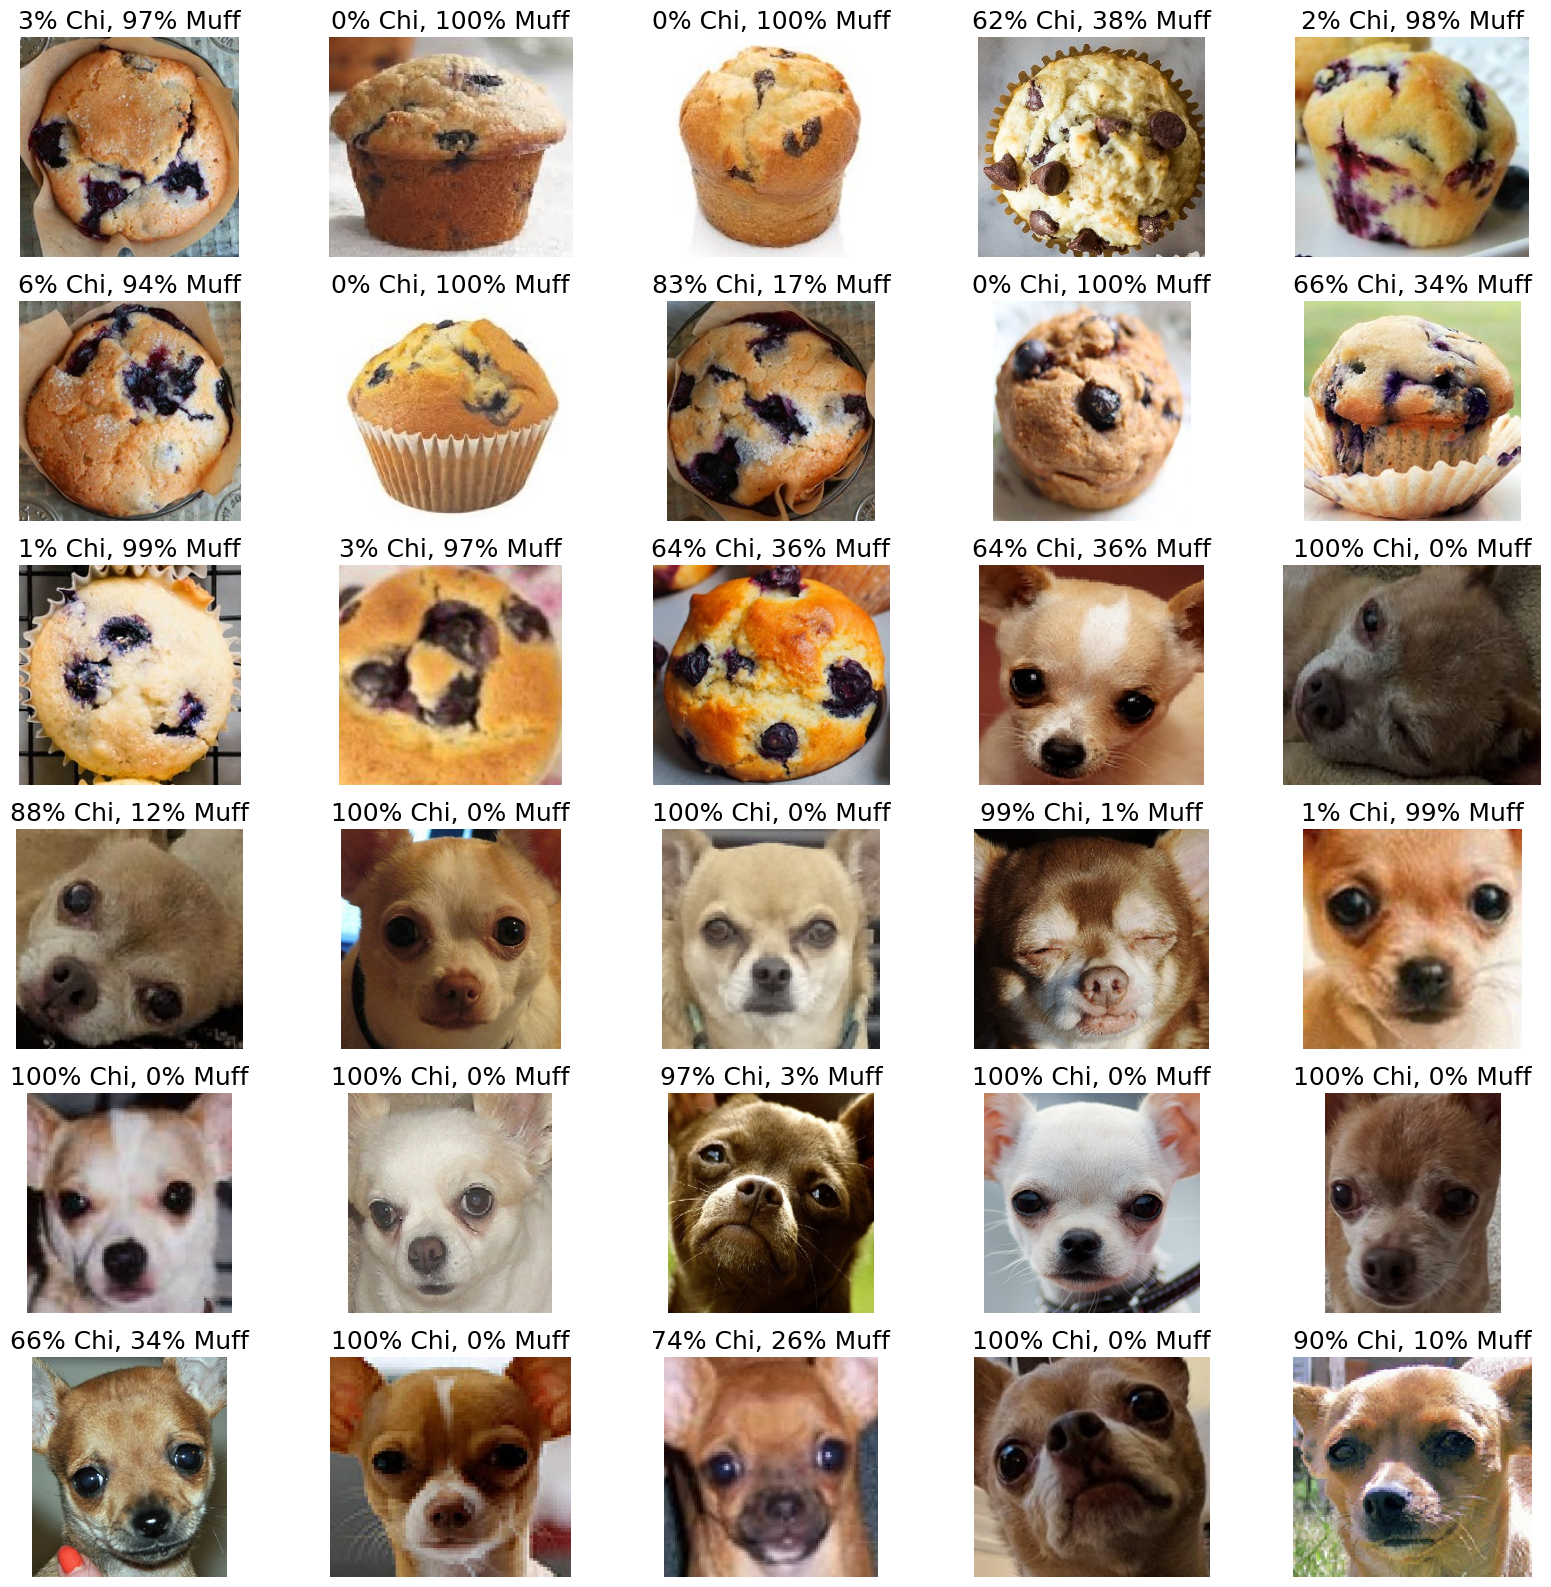

In [205]:
from glob import glob
from math import floor

# get all the images from our validation sets
validation_img_paths = glob("data/validation/**/*.jpg", recursive=True)
images = [Image.open(img_path) for img_path in validation_img_paths]

# put all the images together to run through our model
validation_batch = torch.stack( [validation_transforms(img).to(device) for img in images])
pred_logits_tensor = model(validation_batch)
pred_probs = pred_logits_tensor.cpu().data.numpy()

# show the probabilities for each picture
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, img in enumerate(images):
    ax = axs[floor(i/5)][i % 5]
    ax.axis('off')
    ax.set_title("{:.0f}% Chi, {:.0f}% Muff".format(100*pred_probs[i,0], 100*pred_probs[i,1]), fontsize=18)
    ax.imshow(img)

Attempt3: By increasing the epoch to 50 and the learning rate (lr) to .5, I was able to get the chihuahua images to 94%; however, the muffin images are 57%.

Attempt5:  99% training and 90% validation with 9% gap...
There is no confusion as to which is a muffin or chihuahua. A few of my attempts with larger amounts of epochs, learning rate, layers and neurons in layers resluted in poor results, overfitting and underfitting.

After swapping optimizers I stayed with AdamW. RMSprop and SVG did not perform as well after many attempts with both models keeping between 50% and 76%. The learning rate (lr) performed best at 0.01 with AdamW and I kept the Epochs at 25 attempting to achieve greater accuracy through more loops to train the model on images.

**Consider:** How accurate was your model? How confident were its predictions? Does it make clear-cut decisions?

## Congratulations! You've successfully trained a neural network!

# III.  Can You Do Better?

Now that we've shown you how to train a neural network, can you improve the validation accuracy by tweaking the parameters? **We challenge you to reach 100% accuracy!**

Some parameters to play with:
- Number of epochs
- The learning rate "lr" parameter in the optimizer
- The type of optimizer (https://pytorch.org/docs/stable/optim.html)
- Number of layers and layer dimensions
- Image size
- Data augmentation transforms (https://pytorch.org/docs/stable/torchvision/transforms.html)

# Special Thanks!

Credit for the original idea and code goes to [DeepSense.ai](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/)!
We've modified it significantly to cater to this workshop, and boost the visual appeal.

This tutorial was created through hard work and love by Jing Zhao, Dylan Wang, Jason Do, Jason Jiang, and Andrew Jong.